In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import src.lightbgm as lightgbm_model
import matplotlib.pyplot as plt
import matplotlib.style as style
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
import plotly.io as pio
pio.templates["mod"] = go.layout.Template(layout=dict(font=dict(family="Fira Code")))
pio.templates.default = "plotly_dark+mod"
import seaborn as sns
from sklearn.metrics import roc_auc_score

from collections import Counter, defaultdict
import os
for dirname, _, filenames in os.walk('dataset/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df=pd.read_csv(r'dataset/bank.csv')
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [4]:
df.describe()

age       balance           day      duration      campaign  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948   1528.538524     15.658036    371.993818      2.508421   
std       11.913369   3225.413326      8.420740    347.128386      2.722077   
min       18.000000  -6847.000000      1.000000      2.000000      1.000000   
25%       32.000000    122.000000      8.000000    138.000000      1.000000   
50%       39.000000    550.000000     15.000000    255.000000      2.000000   
75%       49.000000   1708.000000     22.000000    496.000000      3.000000   
max       95.000000  81204.000000     31.000000   3881.000000     63.000000   

              pdays      previous  
count  11162.000000  11162.000000  
mean      51.330407      0.832557  
std      108.758282      2.292007  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       20.750000      1.000000  
max      854.000000     58.000000

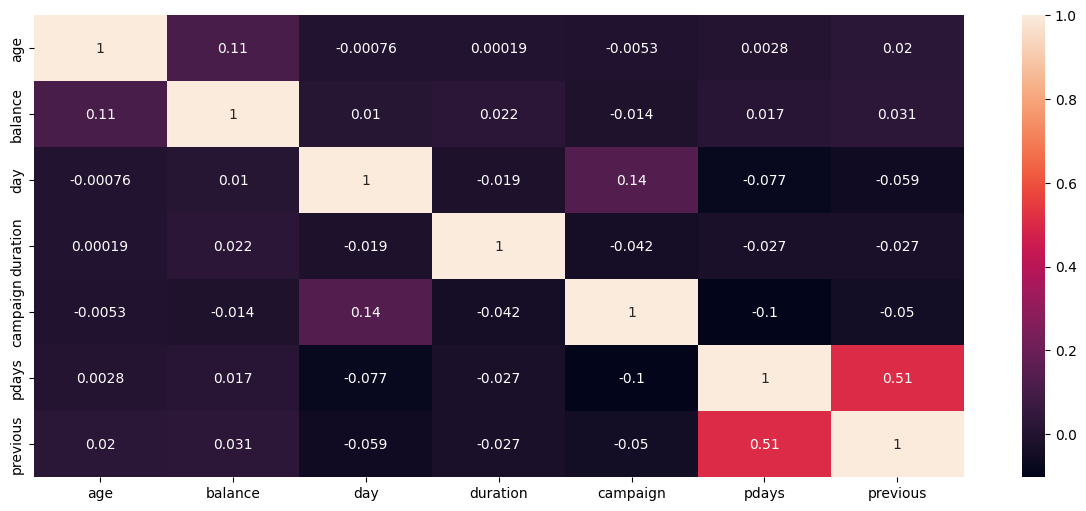

In [5]:

# Select only numeric columns
df_numeric = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr_matrix = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(15,6))
sns.heatmap(corr_matrix, annot=True)
plt.show()


# Age

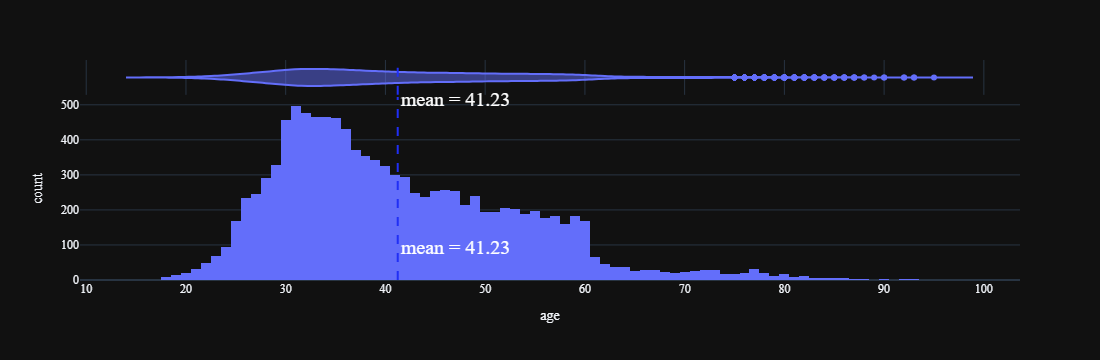

In [6]:
px.histogram(df,x="age",marginal="violin").add_vline(x=df.age.mean(),line=dict(dash="dash",color="#202ff5"),annotation=dict(text=f"mean = {df.age.mean():.2f}",y=0.25,font=dict(color="#ffffff",size=20),align="center"))


Text(0.5, 1.0, 'Age vs Deposit')

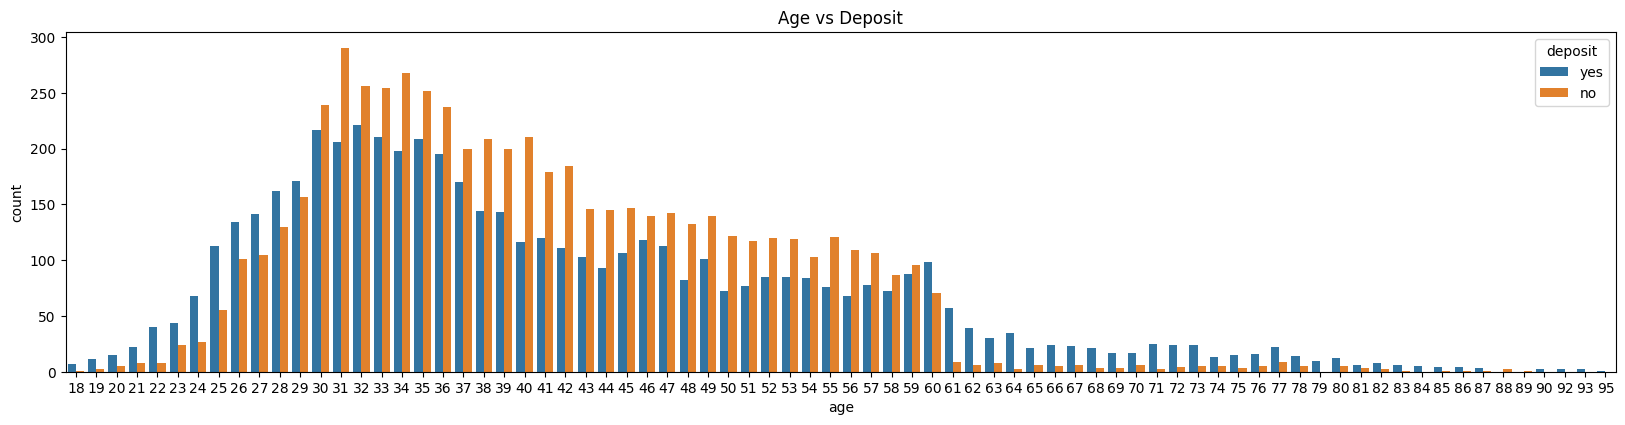

In [7]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,2)
sns.countplot(x = 'age',hue='deposit', data=df)
plt.title('Age vs Deposit')

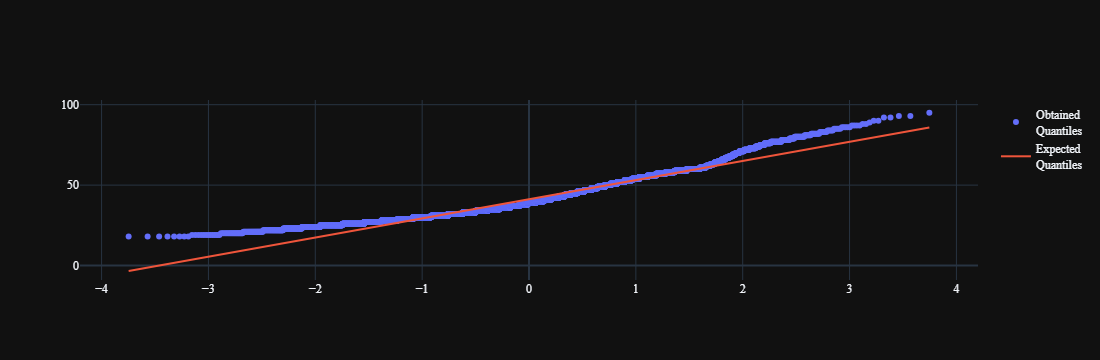

In [8]:
data = sm.qqplot(df.age,line="s").gca().lines
plt.close()
fig = go.Figure()
fig.add_trace(go.Scatter(x=data[0].get_xdata(),y=data[0].get_ydata(),mode="markers",name="Obtained<br>Quantiles"))
fig.add_trace(go.Scatter(x=data[1].get_xdata(),y=data[1].get_ydata(),mode="lines",name="Expected<br>Quantiles"))
fig.update_layout(width=700)

# Job

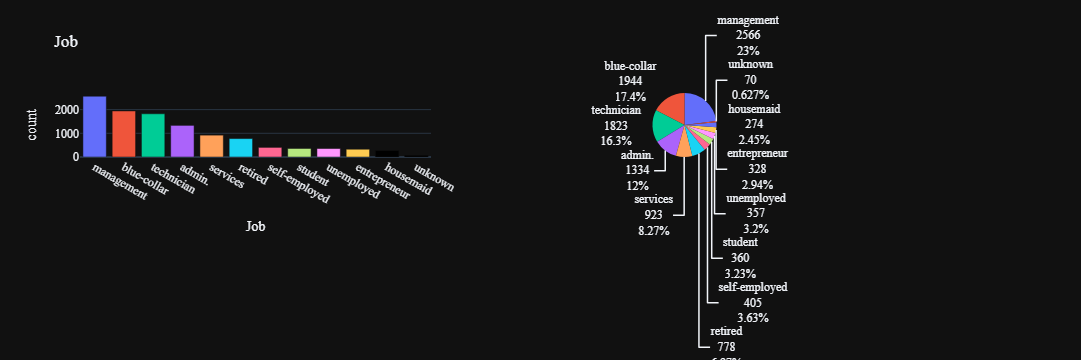

In [9]:
fig = make_subplots(cols=2,specs=[[{"type":"xy"},{"type":"domain"}]])
fig.add_trace(go.Bar(x=df.job.value_counts().index,y=df.job.value_counts(),marker=dict(color=px.colors.qualitative.Plotly)),row=1,col=1)
fig.add_trace(go.Pie(values=df.job.value_counts().to_numpy(),labels=df.job.value_counts().index,textinfo="label+percent+value",marker=dict(colors=px.colors.qualitative.Plotly),sort=False),row=1,col=2)
fig.update_layout(showlegend=False,title="Job")
fig.update_yaxes(title="count")
fig.update_xaxes(title="Job")
fig.show()

Text(0.5, 1.0, 'Job vs Deposit')

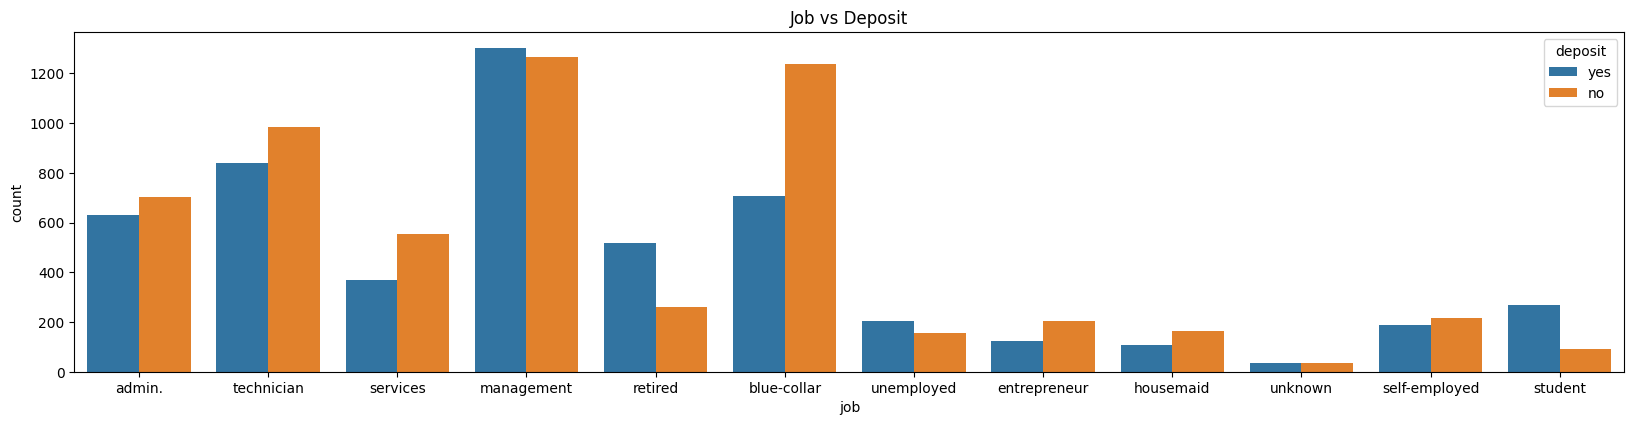

In [10]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
sns.countplot(x = 'job',hue='deposit', data=df)
plt.title('Job vs Deposit')

# Month

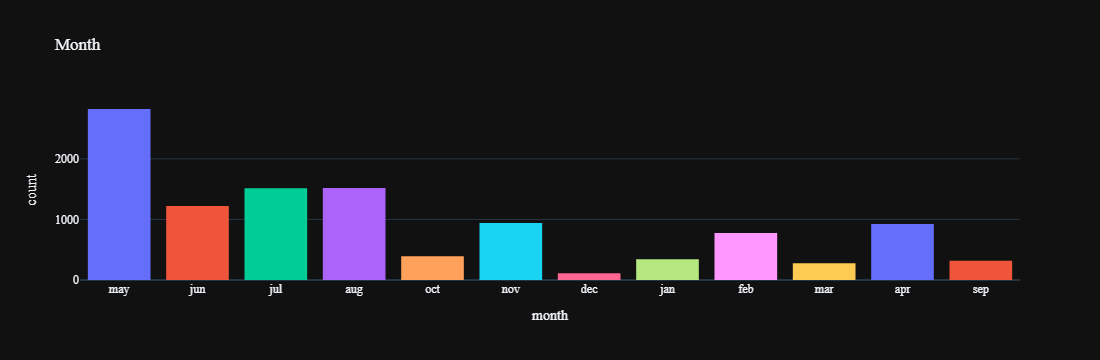

In [11]:
px.histogram(df,x="month",color="month",title="Month").update_layout(showlegend=False)

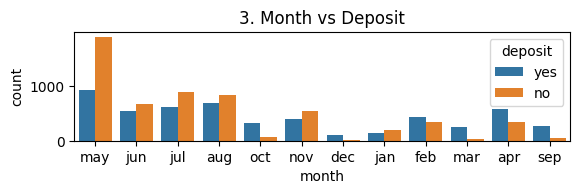

In [12]:
plt.subplot(3,1,3)
sns.countplot(x = 'month',hue='deposit', data=df)
plt.title('3. Month vs Deposit')
plt.show()

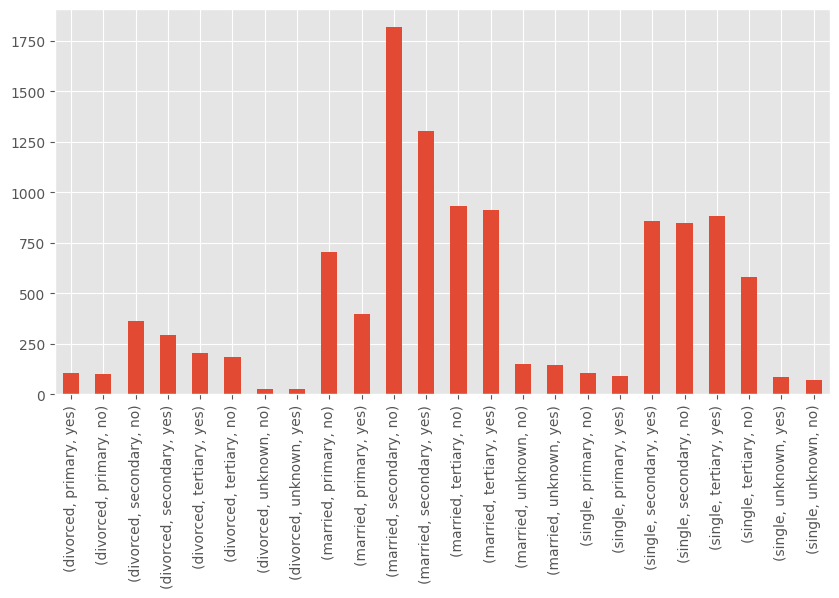

In [13]:

style.use('ggplot')
df.groupby(['marital','education'])['deposit'].value_counts().plot(kind='bar',figsize=(10,5))
plt.xticks(rotation=90)
plt.xlabel(None)
plt.show()

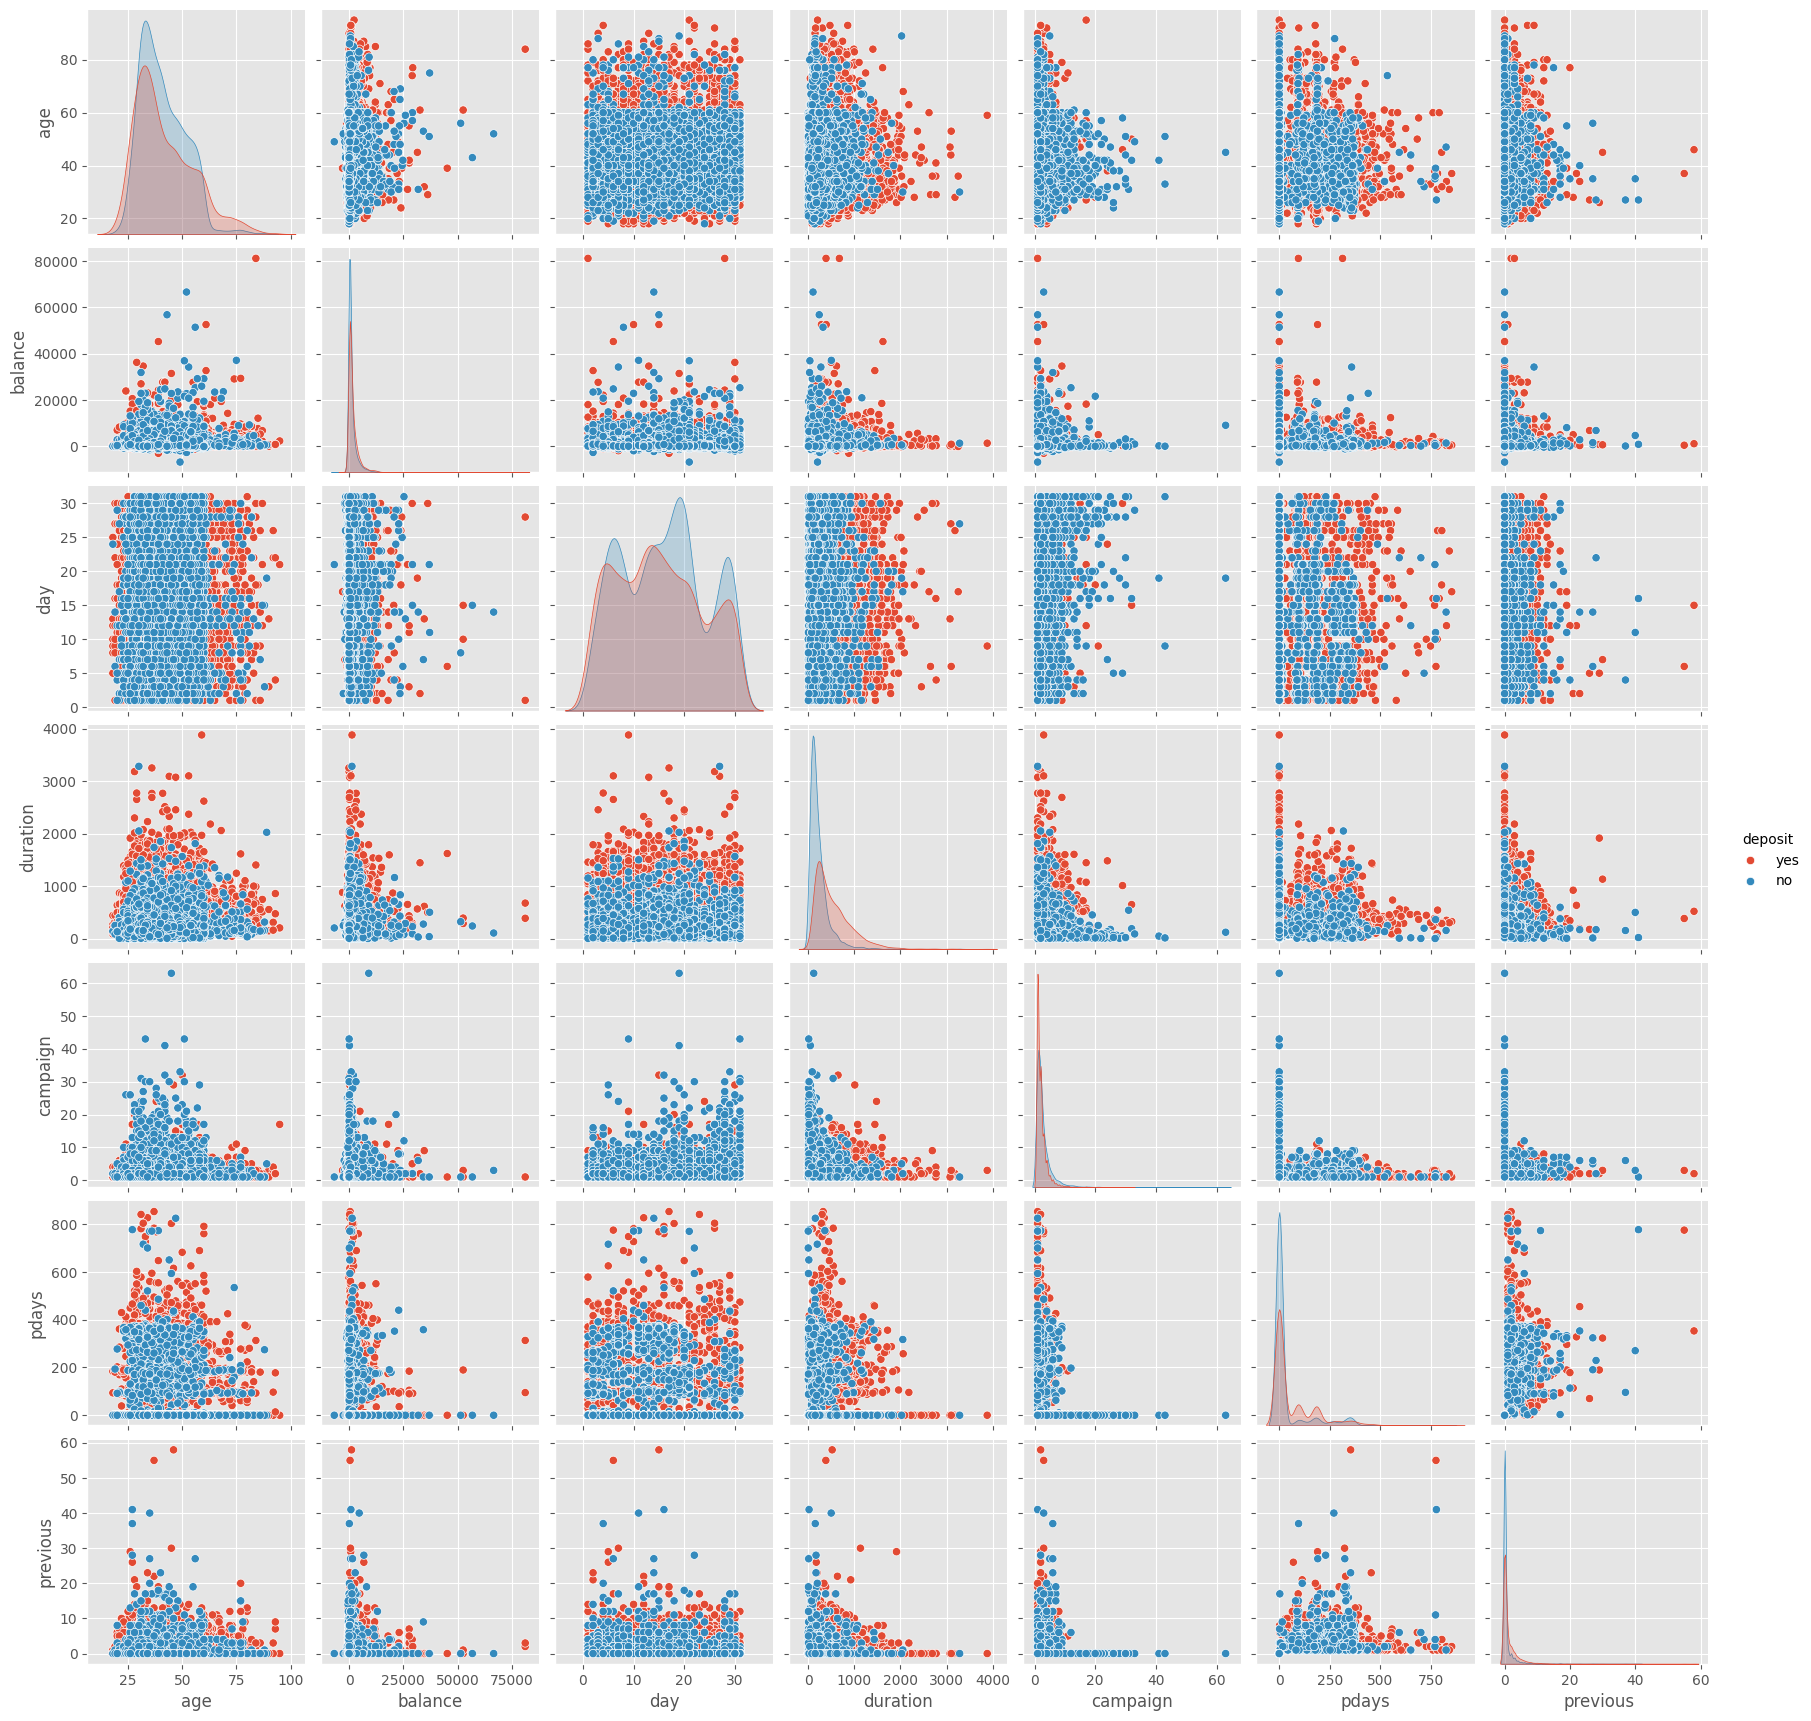

In [14]:
sns.pairplot(data=df,hue='deposit')
plt.show()

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

for col in df:
    if df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df[col].unique())) <= 2:
        
            le.fit(df[col])
            df[col] = le.transform(df[col])
            
           
            le_count += 1

In [16]:
data1=pd.get_dummies(df)

In [17]:
data1.head(2)

age  default  balance  housing  loan  day  duration  campaign  pdays  \
0   59        0     2343        1     0    5      1042         1     -1   
1   56        0       45        0     0    5      1467         1     -1   

   previous  ...  month_jun  month_mar  month_may  month_nov  month_oct  \
0         0  ...      False      False       True      False      False   
1         0  ...      False      False       True      False      False   

   month_sep  poutcome_failure  poutcome_other  poutcome_success  \
0      False             False           False             False   
1      False             False           False             False   

   poutcome_unknown  
0              True  
1              True  

[2 rows x 49 columns]

In [18]:
X=data1.drop(columns='deposit',axis=1)
y=data1.deposit

In [19]:
model_sk, s = lightgbm_model.train_lightgbm(X, y)

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid auc: 0.921784 + 0.00245222
[200]	cv_agg's valid auc: 0.92504 + 0.00268274
[300]	cv_agg's valid auc: 0.927685 + 0.00257178
[400]	cv_agg's valid auc: 0.92883 + 0.00256509
[500]	cv_agg's valid auc: 0.929617 + 0.00263134
[600]	cv_agg's valid auc: 0.930143 + 0.00263045
[700]	cv_agg's valid auc: 0.930234 + 0.00254108
[800]	cv_agg's valid auc: 0.930453 + 0.00263102
[900]	cv_agg's valid auc: 0.930468 + 0.00264812
Early stopping, best iteration is:
[852]	cv_agg's valid auc: 0.930601 + 0.00267516


In [22]:


OOF = s.get_oof(X.shape[0])
roc_auc_score(y, OOF)

0.9302480753435588

<Axes: title={'center': 'Histogram of predictions'}, ylabel='Frequency'>

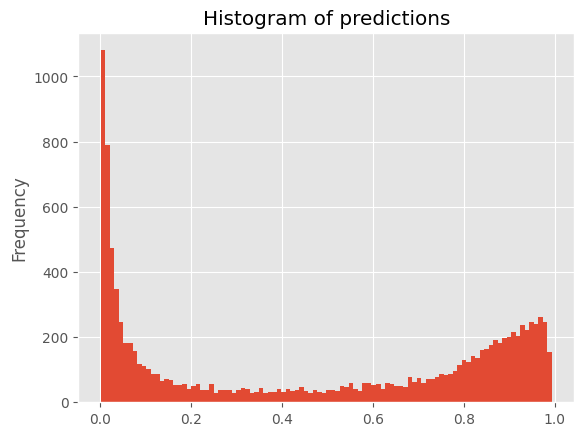

In [23]:
pd.Series(OOF).plot.hist(bins=100, title='Histogram of predictions')

<Axes: title={'center': 'Smoothed OOF prediction'}>

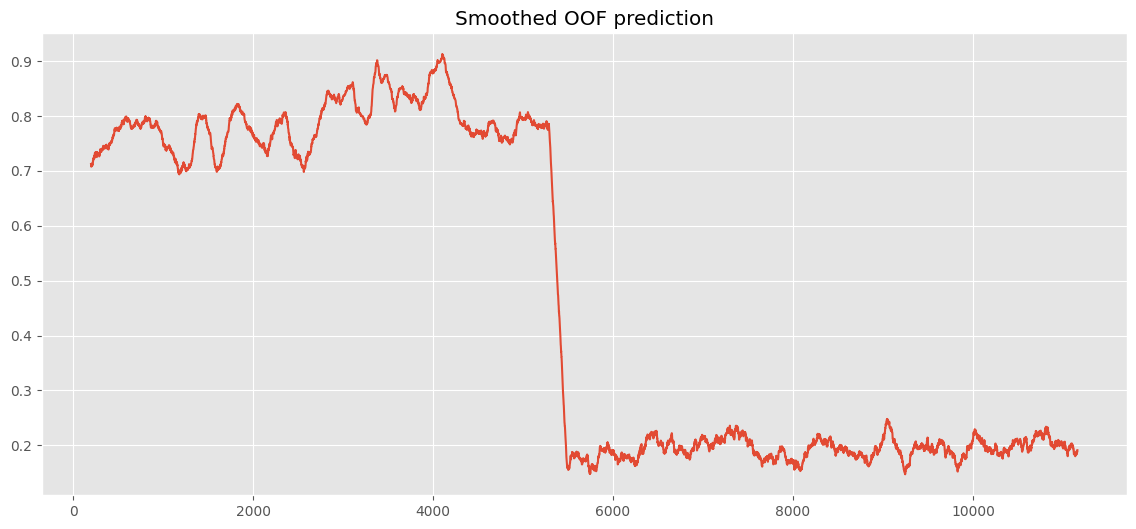

In [24]:
pd.Series(OOF).rolling(200).mean().plot(figsize=(14,6), title='Smoothed OOF prediction')

<Axes: title={'center': 'Adversarial AUC Logs'}>

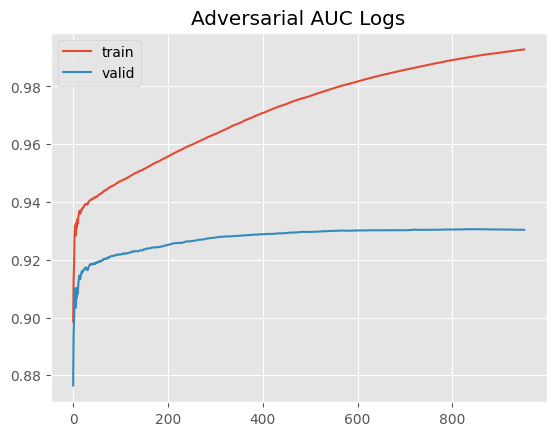

In [25]:
logs = pd.DataFrame({'train':s.train_log().mean(1), 'valid':s.valid_log().mean(1)})
logs.train.plot(legend=True, title='Adversarial AUC Logs')
logs.valid.plot(legend=True)

In [26]:
def make_importances(clf, importance_type):
    return pd.Series(data=clf.feature_importance(importance_type), index=clf.feature_name())

original_feature_names = X.columns.tolist()
feature_mapping = {f"feature_{i}": original_feature_names[i] for i in range(len(original_feature_names))}

IMPORTANCES = pd.concat([make_importances(b, 'gain') for b in s.model.boosters], axis=1).sum(axis=1).to_frame('Gain')
IMPORTANCES['Count'] = pd.concat([make_importances(b, 'split') for b in s.model.boosters], axis=1).sum(axis=1)


IMPORTANCES.sort_values('Gain', ascending=False).head()

Gain  Count
duration  555963.750185  27204
day       108154.351184  24645
balance   101429.116036  29231
age        96628.542822  22840
pdays      89807.859422  16333

<Axes: title={'center': 'Adversarial Feature Gain'}>

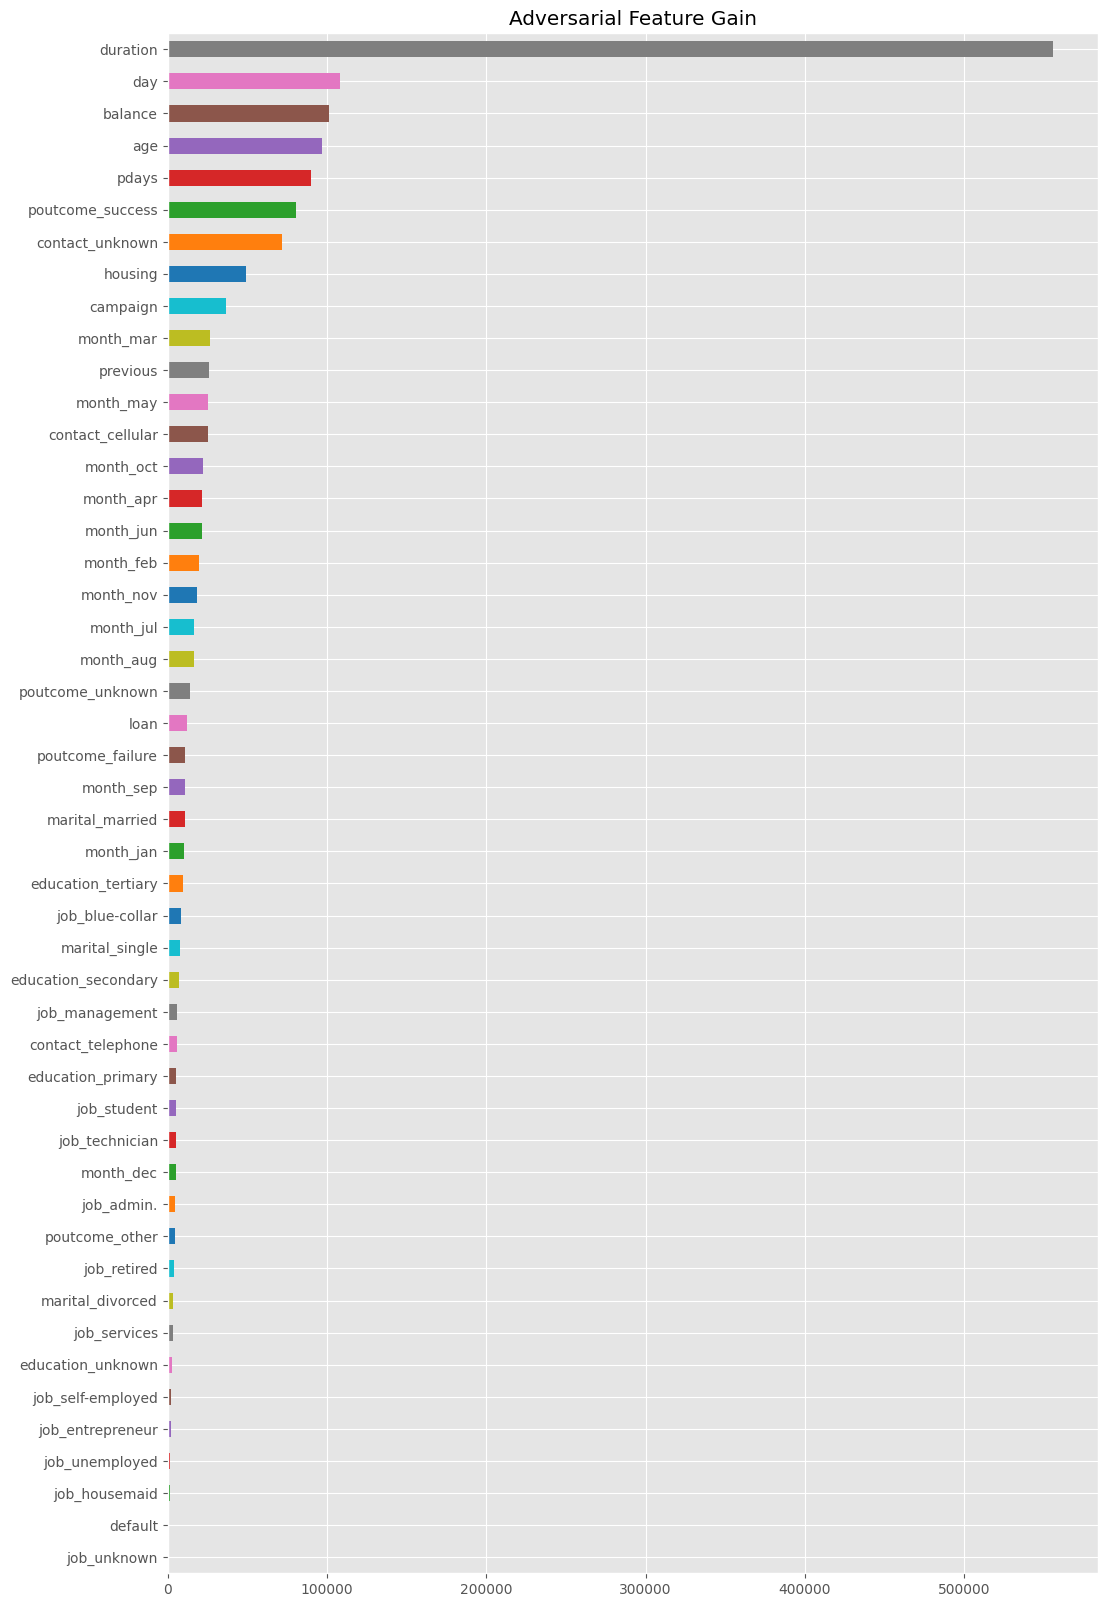

In [27]:
COLORS = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]
toplot = IMPORTANCES.sort_values('Gain').tail(80)
toplot['Gain'].plot.barh(figsize=(12,20), color=COLORS, title='Adversarial Feature Gain')

In [30]:


def get_split_point_stats_multi(clfs):
    split_points = defaultdict(Counter)

    def visit_node(d):
        if 'tree_info' in d:
            for tree in d['tree_info']: # a list of trees
                visit_node(tree)
        for k in ['tree_structure', 'left_child', 'right_child' ]:
            if k in d:
                visit_node(d[k])
        if 'split_feature' in d:
            split_points[names[d['split_feature']]] [d['threshold']] += d['split_gain']

    for clf in clfs:
        names = clf.feature_name()
        visit_node(clf.dump_model())
    return split_points

split_points = get_split_point_stats_multi(s.model.boosters)

In [31]:


MAX_SHOW = 50
ADJS = 'abundant:common:ubiquitous:omnipresent:rampant:rife:permeant:widespread:legendary:popular:fashionable:frequent:usual:useful:predominant:recurrent:repetitive:repetitious:marked:prevalent:prevalent:prevalent'.split(':')

np.random.seed(42)

def plot_it(col):
    counts = split_points[col]
    ser = pd.Series(dict(counts)).sort_values(ascending=False)
    total_gain = IMPORTANCES.loc[col, 'Gain']
    total_splits = IMPORTANCES.loc[col, 'Count']

    if hasattr(col, 'cat'):
        # remap categories from int -> cat value
        try:
            ser.index = col.cat.categories[ser.index.astype(int)]
        except:
            # e.g. TypeError: Cannot cast Index to dtype <class 'int'>
            # a categorical with many categories and '1||4||7' etc type splits
            # leave it as it is
            pass
    adj = np.random.choice(ADJS)
    display(
        HTML(
            f'<h1 id="plot_{col}">{col}</h1>'
            f'<p>Used {total_splits} times, total gain is {total_gain}.'
            f'<p>{len(ser)} split point values used. '
            f'Most {adj} is {ser.index[0]} with gain of {ser.values[0]}.'
        )
    )
    ser = ser.head(MAX_SHOW).sort_index()
    ax = ser.plot.bar(title=f'{col} — Adversarial split points by gain',
                      rot=90, fontsize=12, figsize=(15,5),
                      width=0.7, color=COLORS)
    plt.show()

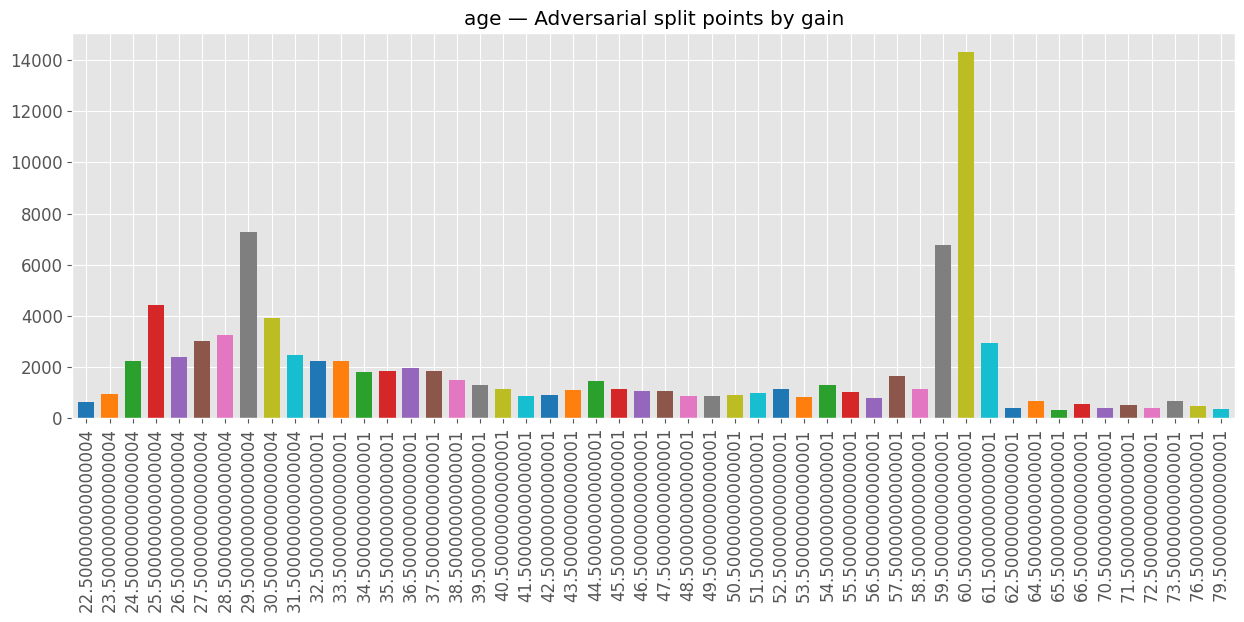

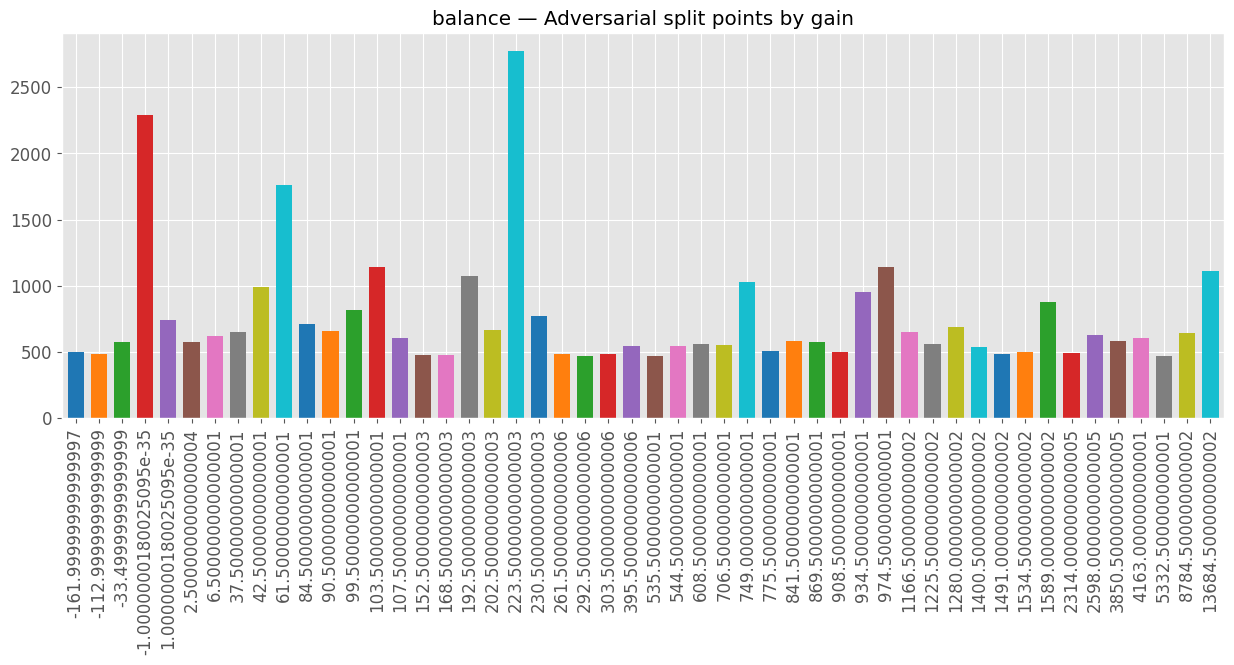

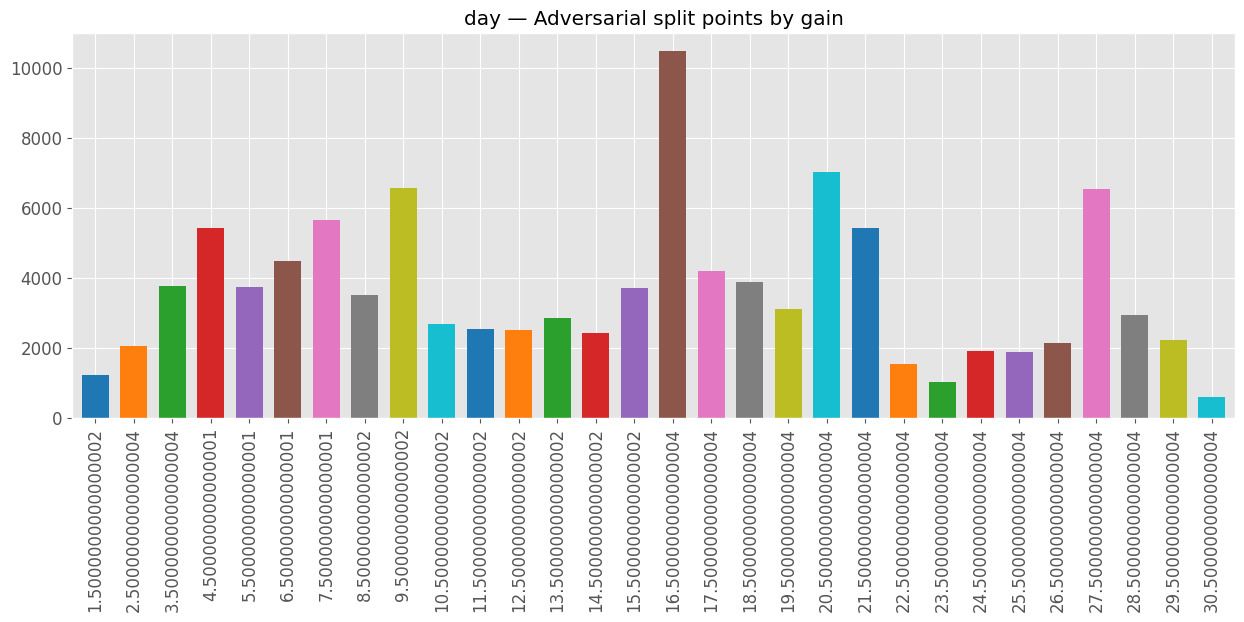

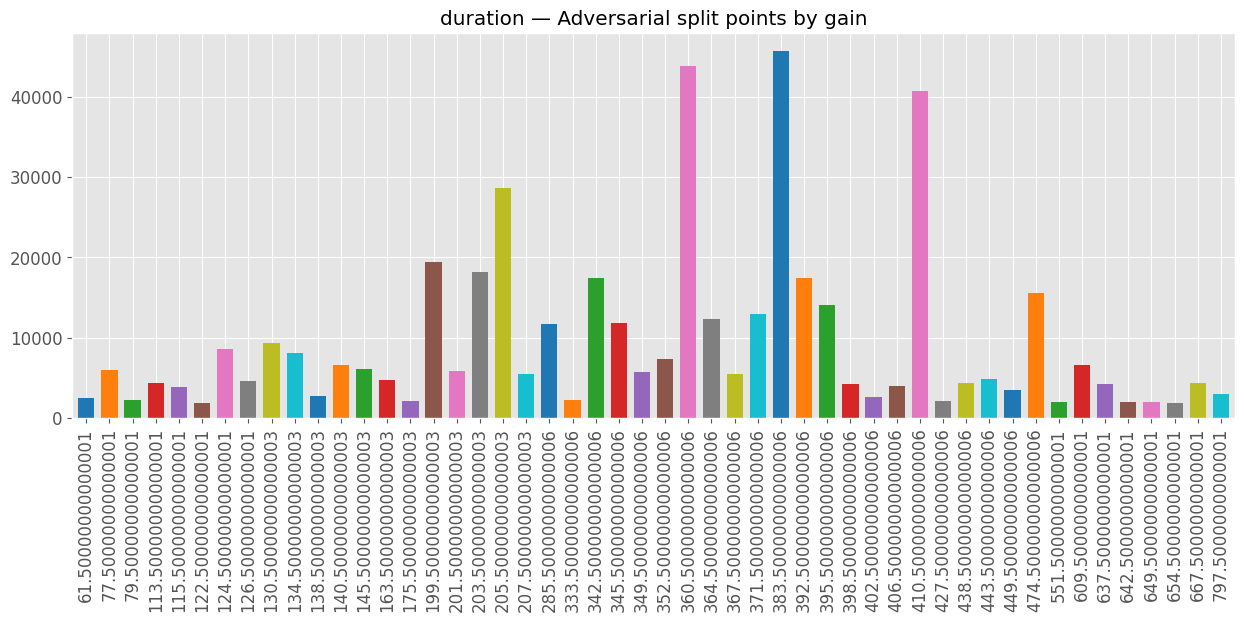

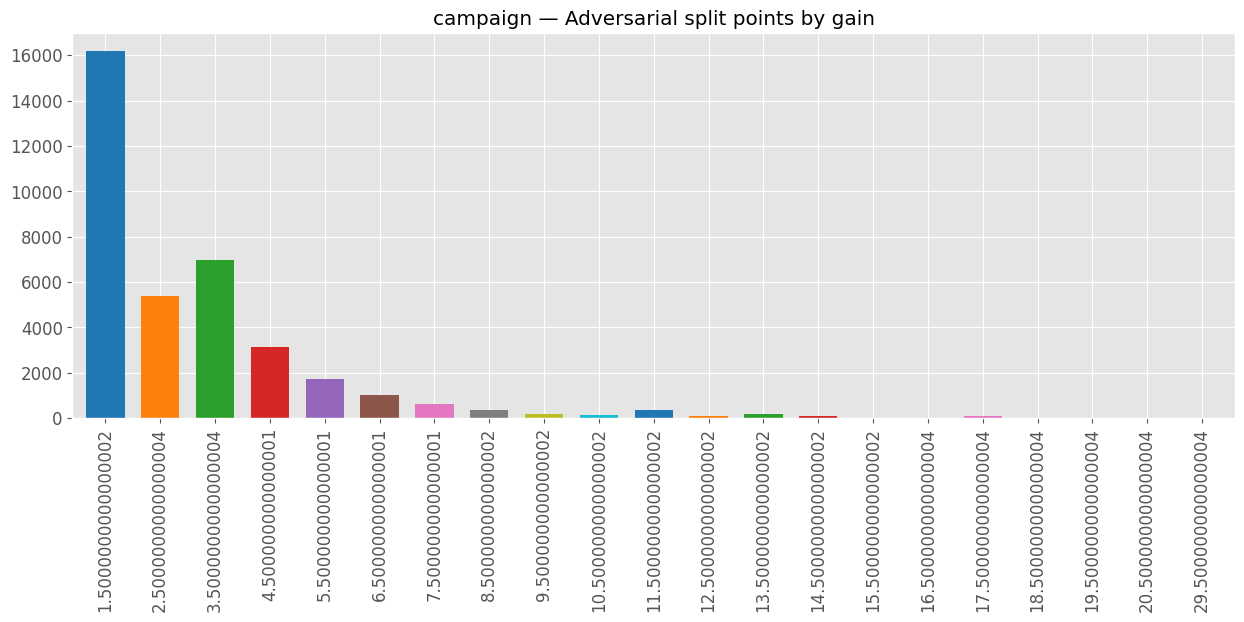

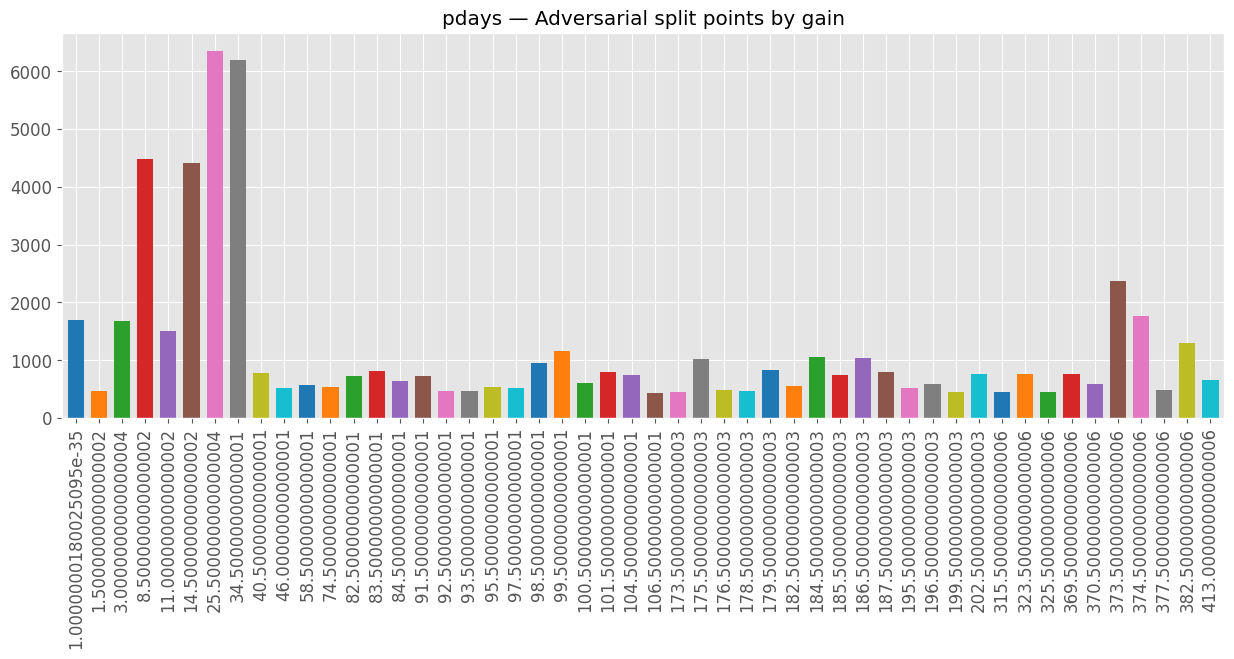

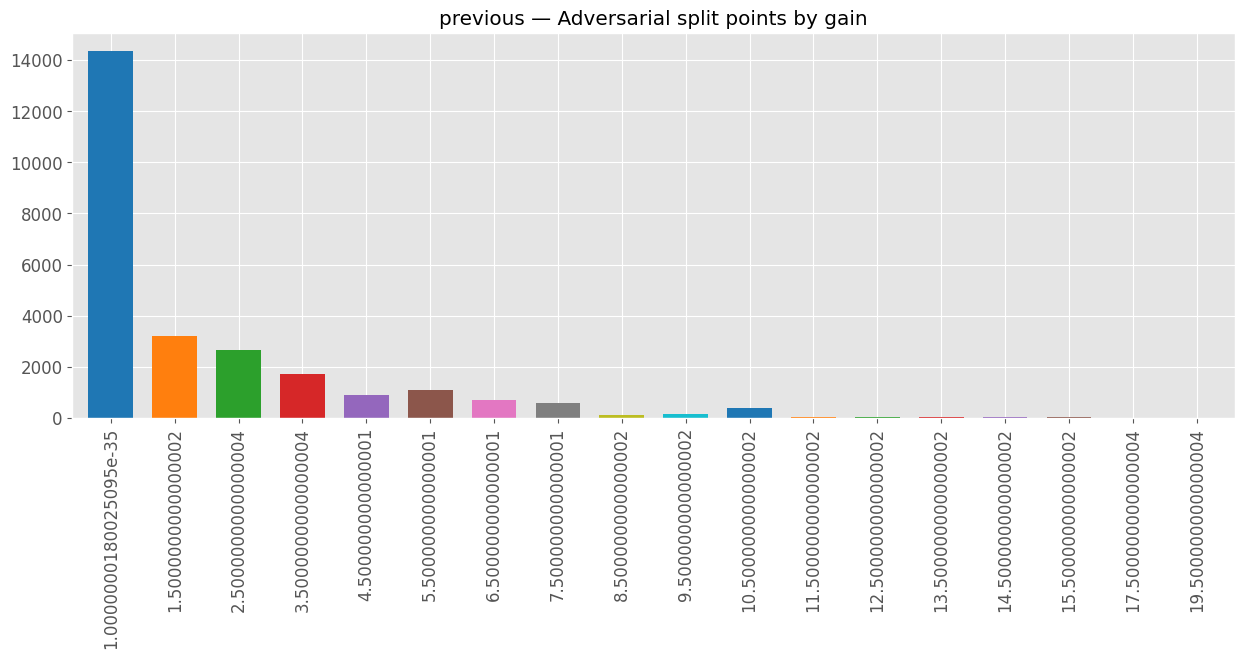

In [32]:

from IPython.display import display, Image, HTML

for col in X.columns.tolist():
    counts = split_points[col]
    if len(counts) >= 2:
        plot_it(col)